### 1. Installation, imports et configs

#### 1.2- Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

random.seed(42)

2025-10-08 19:27:02.078684: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 19:27:07.120485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 19:27:22.936000: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


#### 1.3- Configs

In [19]:
class ProjectConfig:
    """Configuration centralisée du projet"""

    def __init__(self, project_dir="/run/media/kjd/working/projects/IA/Stage_INSEED/OCR_CNN_MNIST_2"):
        self.project_dir = project_dir
        self.base_data_dir = os.path.join(project_dir, "Data")
        self.base_model_dir = os.path.join(project_dir, "Models")
        self.base_output_dir = os.path.join(project_dir, "Outputs")
        self.processed_data_dir = os.path.join(project_dir, "Processed_Data")

        # Fichiers de données
        self.train_data_file = os.path.join(self.base_data_dir, "train.csv")
        self.ftest_data_file = os.path.join(self.base_data_dir, "test.csv")

        # Répertoires de sortie
        self.output_graphics_dir = os.path.join(self.base_output_dir, "graphics")
        self.model_checkpoints_dir = os.path.join(self.base_model_dir, "checkpoints")
        self.training_logs_dir = os.path.join(self.base_output_dir, "training_logs")

        # Création des répertoires
        self._create_directories()

    def _create_directories(self):
        """Crée tous les répertoires nécessaires"""
        directories = [
            self.base_output_dir, self.output_graphics_dir,
            self.base_model_dir, self.model_checkpoints_dir,
            self.training_logs_dir, self.processed_data_dir
        ]

        for directory in directories:
            os.makedirs(directory, exist_ok=True)

    def get_model_path(self, model_name):
        """Retourne le chemin pour sauvegarder un modèle"""
        return os.path.join(self.base_model_dir, f"{model_name}.keras")

    def get_checkpoint_path(self, model_name, epoch):
        """Retourne le chemin pour un checkpoint d'epoch"""
        return os.path.join(self.model_checkpoints_dir, f"{model_name}_epoch_{epoch}.keras")

    def get_training_log_path(self, model_name):
        """Retourne le chemin pour les logs d'entraînement"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        return os.path.join(self.training_logs_dir, f"{model_name}_training_{timestamp}.csv")

# Initialisation de la configuration
config = ProjectConfig()

### 2. Différentes classes

#### 2.1- Preprocessing des données

In [29]:
class DataPreprocessor:
    """Classe pour le prétraitement des données MNIST"""

    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
        self.preprocessing_params = {}

    def load_data(self):
        """Charge les données brutes"""
        print("Chargement des données...")
        self.train_data = pd.read_csv(self.config.train_data_file)
        self.ftest_data = pd.read_csv(self.config.ftest_data_file)

        print(f"Train data shape: {self.train_data.shape}")
        print(f"Test data shape: {self.ftest_data.shape}")

        return self.train_data, self.ftest_data

    def preprocess_data(self, random_state=42):
        """Prétraite les données pour l'entraînement"""

        if os.path.exists(os.path.join(self.config.processed_data_dir, 'preprocessed_data.pkl')):
            print("Données prétraitées existantes en cache. Chargement ...")
            return self.load_preprocessed_data()
        else : 
            print("Prétraitement des données...")

            # Séparation features/target
            X = self.train_data.iloc[:, 1:].values.astype('float32')
            #X = self.train_data.iloc[:, 1:].values
            y = self.train_data.iloc[:, 0].values

            # Normalisation
            X = X / 255.0
            self.ftest_data = self.ftest_data.values.astype('float32') / 255.0

            # Standardisation
            #X = self.scaler.fit_transform(X)
            #self.test_data = self.scaler.transform(self.test_data.values)

            # Reshape pour CNN
            X = X.reshape(-1, 28, 28, 1)
            self.ftest_data = self.ftest_data.reshape(-1, 28, 28, 1)

            # Encodage one-hot des labels
            #y = to_categorical(y, 10)

            # Split train/validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, 
                                                                test_size=0.2, 
                                                                random_state=random_state, 
                                                                stratify=y)
            
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.476, random_state=random_state, stratify=y_temp)

            """X_train, X_val, y_train, y_val = train_test_split(
                X, y,
                test_size=validation_size, 
                random_state=random_state, 
                stratify=y
            )"""

            # Sauvegarde des paramètres de prétraitement
            self.preprocessing_params = {
                'validation_size': len(X_val) / len(X),
                'test_size': len(X_test) / len(X),
                'random_state': random_state,
                'input_shape': (28, 28, 1),
                'num_classes': 10
            }

            # Sauvegarde des données prétraitées
            self._save_preprocessed_data(X_train, X_val, X_test, y_train, y_val, y_test)

            return X_train, X_val, X_test, y_train, y_val, y_test, self.ftest_data

    def _save_preprocessed_data(self, X_train, X_val, X_test, y_train, y_val, y_test):
        """Sauvegarde les données prétraitées"""
        processed_data = {
            'X_train': X_train,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test,
            'ftest_data': self.ftest_data,
            'preprocessing_params': self.preprocessing_params
        }

        with open(os.path.join(self.config.processed_data_dir, 'preprocessed_data.pkl'), 'wb') as f:
            pickle.dump(processed_data, f)

        print("Données prétraitées sauvegardées.")

    def load_preprocessed_data(self):
        """Charge les données prétraitées"""
        file_path = os.path.join(self.config.processed_data_dir, 'preprocessed_data.pkl')

        if os.path.exists(file_path):
            with open(file_path, 'rb') as f:
                processed_data = pickle.load(f)

            self.preprocessing_params = processed_data['preprocessing_params']
            print("Données prétraitées chargées.")
            return (processed_data['X_train'], processed_data['X_val'], processed_data['X_test'],
                   processed_data['y_train'], processed_data['y_val'], processed_data['y_test'],
                   processed_data['ftest_data'])
        else:
            print("Aucune donnée prétraitée trouvée. Exécutez preprocess_data() d'abord.")
            return None

#### 2.2- Visualisations

In [30]:
class DataVisualizer:
    """Classe pour la visualisation des données et résultats"""

    def __init__(self, config):
        self.config = config

    def plot_sample_images(self, X, num_samples=10, save_fig=False):
        """Affiche un échantillon d'images"""
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        axes = axes.ravel()

        for i in range(num_samples):
            idx = random.randint(0, len(X) - 1)
            axes[i].imshow(X[idx].reshape(28, 28))
            #axes[i].set_title(f'Label: {y[idx]}')
            axes[i].axis('off')

        plt.tight_layout()

        if save_fig:
            plt.savefig(os.path.join(self.config.output_graphics_dir, 'sample_images.png'),
                       dpi=300, bbox_inches='tight')
        plt.show()

    def plot_sample_images_with_label(self, X, y, num_samples=10, save_fig=False):
        """Affiche un échantillon d'images avec les annotations"""
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        axes = axes.ravel()

        for i in range(num_samples):
            idx = random.randint(0, len(X) - 1)
            axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
            #axes[i].set_title(f'Label: {np.argmax(y[idx])}')
            axes[i].set_title(f'Label: {y[idx]}')
            axes[i].axis('off')

        plt.tight_layout()

        if save_fig:
            plt.savefig(os.path.join(self.config.output_graphics_dir, 'sample_images_with_labels.png'),
                       dpi=300, bbox_inches='tight')
        plt.show()

    def plot_class_distribution(self, y, dataset_name="Train", save_fig=False):
        """Affiche la distribution des classes"""
        class_counts = np.sum(y, axis=0) if len(y.shape) > 1 else np.bincount(y)

        plt.figure(figsize=(10, 6))
        plt.bar(range(10), class_counts)
        plt.title(f'Distribution des classes - {dataset_name}')
        plt.xlabel('Chiffre')
        plt.ylabel("Nombre d'échantillons")
        plt.xticks(range(10))

        for i, count in enumerate(class_counts):
            plt.text(i, count, str(int(count)), ha='center', va='bottom')

        if save_fig:
            plt.savefig(os.path.join(self.config.output_graphics_dir,
                                   f'class_distribution_{dataset_name.lower()}.png'),
                       dpi=300, bbox_inches='tight')
        plt.show()

    def plot_training_history(self, history, save_fig=False):
        """Affiche l'historique d'entraînement"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy
        ax1.plot(history.history['accuracy'], label='Train Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Accuracy du modèle')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # Loss
        ax2.plot(history.history['loss'], label='Train Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Loss du modèle')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        if save_fig:
            plt.savefig(os.path.join(self.config.output_graphics_dir, 'training_history.png'),
                       dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, save_fig=False):
        """Affiche la matrice de confusion"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=range(10), yticklabels=range(10))
        plt.title('Matrice de Confusion')
        plt.xlabel('Prédictions')
        plt.ylabel('Vraies valeurs')

        if save_fig:
            plt.savefig(os.path.join(self.config.output_graphics_dir, 'confusion_matrix.png'),
                       dpi=300, bbox_inches='tight')
        plt.show()

#### 2.3- Model

In [31]:
class CNNModel:
    """Classe pour la création et l'entraînement du modèle CNN"""

    def __init__(self, config, input_shape=(28, 28, 1), num_classes=10):
        self.config = config
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self, model_name="baseline_cnn"):
        """Construit le modèle CNN"""
        print(f"Construction du modèle: {model_name}")

        self.model = Sequential([
            # Couche d'entrée
            Input(self.input_shape),

            # Première couche convolutionnelle
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPool2D((2, 2)),
            Dropout(0.25),

            # Deuxième couche convolutionnelle
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPool2D((2, 2)),
            Dropout(0.25),

            # Troisième couche convolutionnelle
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Dropout(0.25),

            # Couches fully connected
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])

        # Compilation du modèle
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            #loss='categorical_crossentropy',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        print("Modèle compilé avec succès!")
        return self.model

    def get_callbacks(self, model_name):
        """Retourne les callbacks pour l'entraînement"""
        checkpoint_cb = ModelCheckpoint(
            self.config.get_checkpoint_path(model_name, "{epoch:02d}"),
            save_best_only=False,
            save_weights_only=False,
            verbose=1
        )

        early_stopping_cb = EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr_cb = ReduceLROnPlateau(
            monitor = 'val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )

        csv_logger_cb = CSVLogger(
            self.config.get_training_log_path(model_name)
        )

        return [checkpoint_cb, early_stopping_cb, reduce_lr_cb, csv_logger_cb]

    def train(self, X_train, y_train, X_val, y_val,
              model_name="mnist_cnn", epochs=20, batch_size=64):
        """Entraîne le modèle"""
        print(f"Début de l'entraînement pour {epochs} epochs...")

        # Data augmentation
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1
        )

        # Entraînement avec data augmentation
        self.history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=self.get_callbacks(model_name),
            verbose=1
        )

        # Sauvegarde du modèle final
        final_model_path = self.config.get_model_path(model_name)
        self.model.save(final_model_path)
        print(f"Modèle final sauvegardé: {final_model_path}")

        return self.history

    def evaluate(self, X_test, y_test):
        """Évalue le modèle sur les données de test"""
        if self.model is None:
            print("Aucun modèle chargé. Veuillez charger ou entraîner un modèle d'abord.")
            return None

        print("Évaluation du modèle...")
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)

        print(f"Loss sur le test set: {loss:.4f}")
        print(f"Accuracy sur le test set: {accuracy:.4f}")

        return loss, accuracy

    def predict(self, X):
        """Fait des prédictions"""
        if self.model is None:
            print("Aucun modèle chargé.")
            return None

        predictions = self.model.predict(X)
        return np.argmax(predictions, axis=1)

    def load_model(self, model_path):
        """Charge un modèle sauvegardé"""
        self.model = load_model(model_path)
        print(f"Modèle chargé: {model_path}")
        return self.model

#### 2.4- Pipeline

In [32]:
class MNISTPipeline:
    """Pipeline principal pour le projet OCR MNIST"""

    def __init__(self):
        self.config = ProjectConfig()
        self.preprocessor = DataPreprocessor(self.config)
        self.visualizer = DataVisualizer(self.config)
        self.train_data, self.test_data = self.preprocessor.load_data()
        #self.idxs = random.sample(range(len((self.preprocessor.load_data())[0])), 10)
        self.model = None

    def run_full_pipeline(self, model_name="mnist_cnn_final", epochs=20):
        """Exécute le pipeline complet"""
        print("=== DÉBUT DU PIPELINE OCR MNIST ===")

        # 1. Prétraitement des données
        print("\n1. PRÉTRAITEMENT DES DONNÉES")
        X_train, X_val, X_test, y_train, y_val, y_test, _ = self.preprocessor.preprocess_data()

        # 2. Visualisation des données
        print("\n2. VISUALISATION DES DONNÉES")
        self.visualizer.plot_sample_images(X_train, y_train, save_fig=True)
        self.visualizer.plot_class_distribution(y_train, "Train", save_fig=True)

        # 3. Construction et entraînement du modèle
        print("\n3. CONSTRUCTION ET ENTRAÎNEMENT DU MODÈLE")
        self.model = CNNModel(self.config)
        self.model.build_model(model_name)

        # Afficher le résumé du modèle
        self.model.model.summary()

        # Entraînement
        history = self.model.train(X_train, y_train, X_val, y_val,
                                 model_name=model_name, epochs=epochs)

        # 4. Visualisation des résultats
        print("\n4. VISUALISATION DES RÉSULTATS")
        self.visualizer.plot_training_history(history, save_fig=True)

        # 5. Évaluation finale
        print("\n5. ÉVALUATION FINALE")
        loss, accuracy = self.model.evaluate(X_test, y_test)

        # Prédictions et matrice de confusion
        y_pred = self.model.predict(X_test)
        y_true = y_test

        self.visualizer.plot_confusion_matrix(y_true, y_pred, save_fig=True)

        # Rapport de classification
        print("\nRapport de classification:")
        print(classification_report(y_true, y_pred))

        print("\n=== PIPELINE TERMINÉ ===")

        return {
            'history': history,
            'test_accuracy': accuracy,
            'test_loss': loss,
            'predictions': y_pred,
            'true_labels': y_true
        }

    def load_and_evaluate(self, model_path, use_preprocessed=True):
        """Charge un modèle et des données pour évaluation"""
        print("Chargement du modèle pour évaluation...")

        self.model = CNNModel(self.config)
        self.model.load_model(model_path)

        if use_preprocessed:
            data = self.preprocessor.load_preprocessed_data()
            if data:
                _, _, X_test, _, _, y_test, _ = data
                return self.model.evaluate(X_test, y_test)

        return None

### 3. Running

#### Initialisation du projet

In [33]:
print("=== PROJET OCR AVEC CNN SUR MNIST ===")
print("Configuration du projet...")
pipeline = MNISTPipeline()
print("Projet configuré avec succès.")

=== PROJET OCR AVEC CNN SUR MNIST ===
Configuration du projet...
Chargement des données...
Train data shape: (42000, 785)
Test data shape: (28000, 784)
Projet configuré avec succès.


#### 3.1- Pipeline complet

In [34]:
run_full = False
if __name__ == "__main__" and run_full == True:
    print("Execution ...")
    results = pipeline.run_full_pipeline(epochs=30)
else : print("Conditions non remplies.")

Conditions non remplies.


#### 3.2- Exploration des données

In [35]:
print("=== EXPLORATION DES DONNÉES ===")

# Chargement des données brutes
train_data, ftest_data = pipeline.preprocessor.load_data()

# Affichage des informations de base
print(f"Shape train data: {train_data.shape}")
print(f"Shape final test data: {ftest_data.shape}")
print(f"Colonnes: {train_data.columns[:10].tolist()}...") 

# Vérification des valeurs manquantes
print(f"Valeurs manquantes dans train: {train_data.isnull().sum().sum()}")

=== EXPLORATION DES DONNÉES ===
Chargement des données...
Train data shape: (42000, 785)
Test data shape: (28000, 784)
Shape train data: (42000, 785)
Shape final test data: (28000, 784)
Colonnes: ['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8']...
Valeurs manquantes dans train: 0


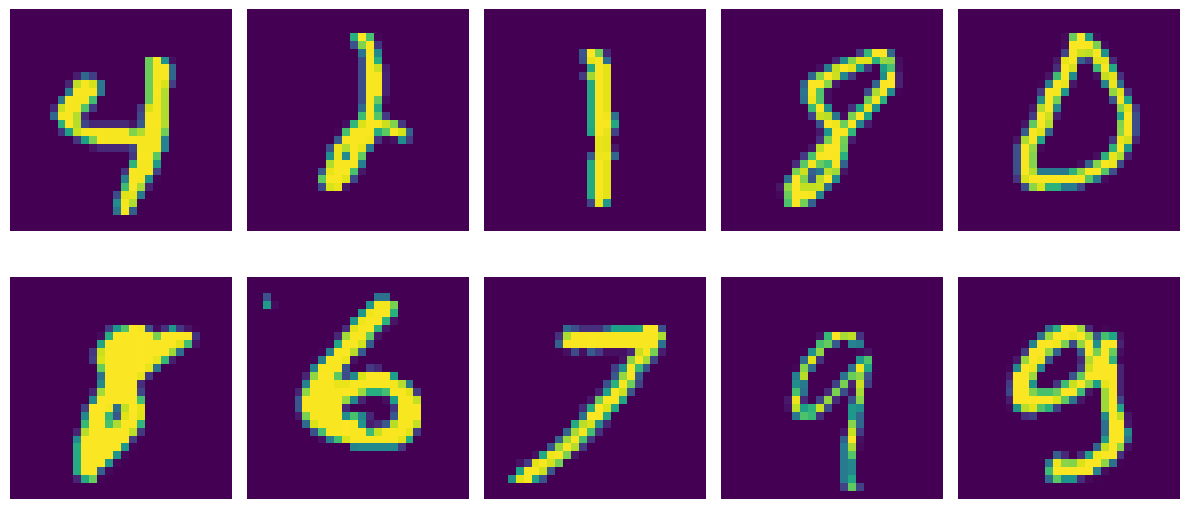

In [36]:
pipeline.visualizer.plot_sample_images(train_data.iloc[:, 1:].values, save_fig=True)

#### 3.3- Prétraintement des données

In [ ]:
print("=== PRÉTRAITEMENT DES DONNÉES ===")

X_train, X_val, X_test, y_train, y_val, y_test, ftest = pipeline.preprocessor.preprocess_data()

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test shape: {ftest.shape}")

=== PRÉTRAITEMENT DES DONNÉES ===
Prétraitement des données...
Données prétraitées sauvegardées.
X_train shape: (33600, 28, 28, 1)
X_val shape: (4401, 28, 28, 1)
X_val shape: (3999, 28, 28, 1)
y_train shape: (33600,)
y_val shape: (4401,)
y_val shape: (3999,)
X_test shape: (28000, 28, 28, 1)


#### 3.4- Visualisation avant training

=== VISUALISATION DES DONNÉES ===


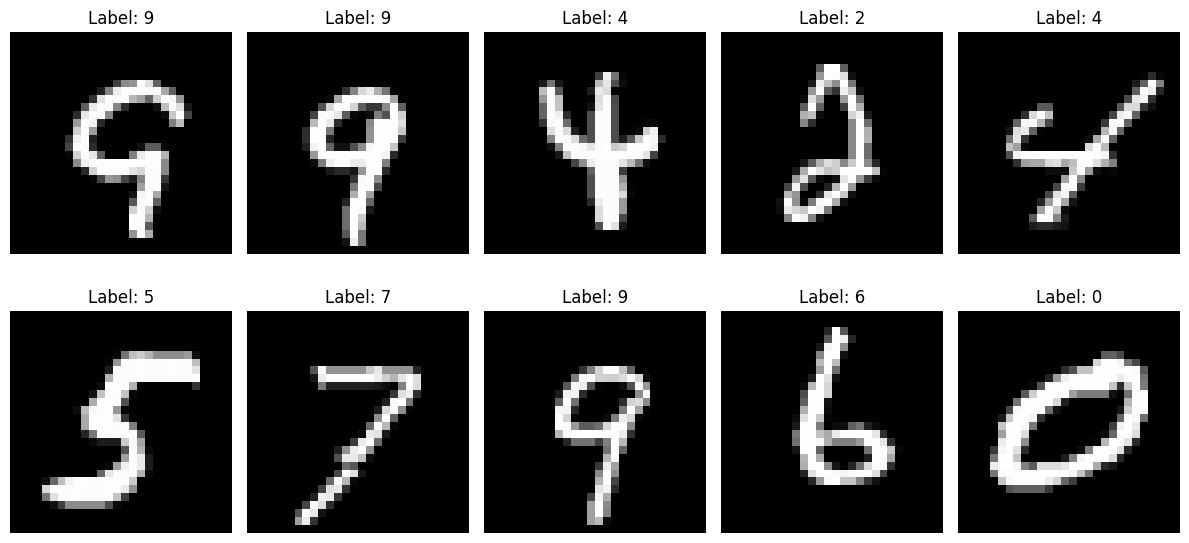

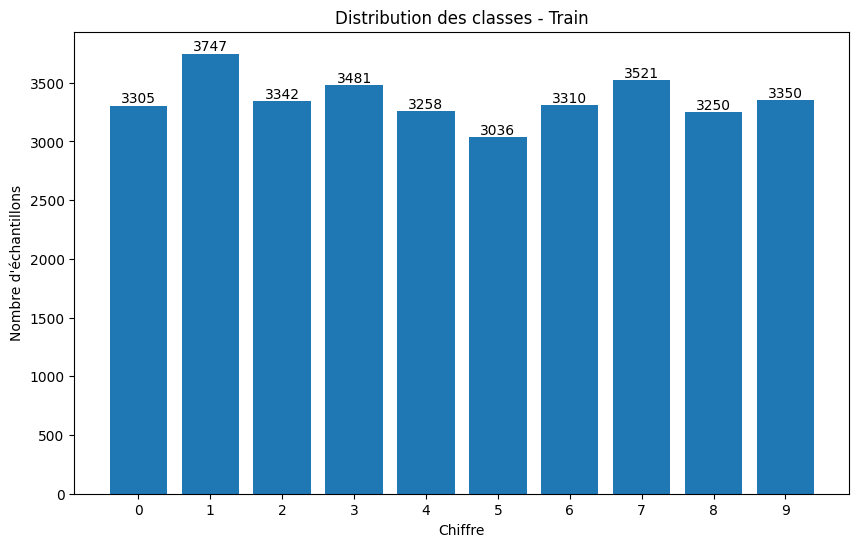

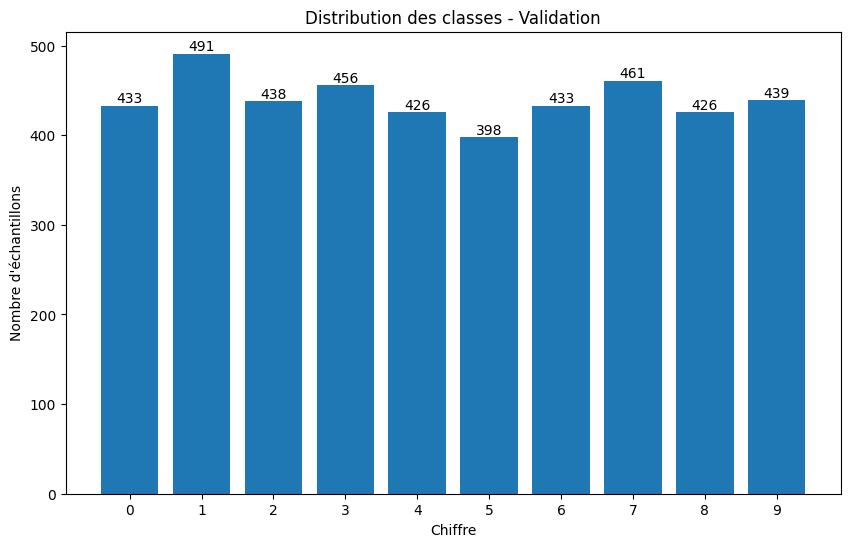

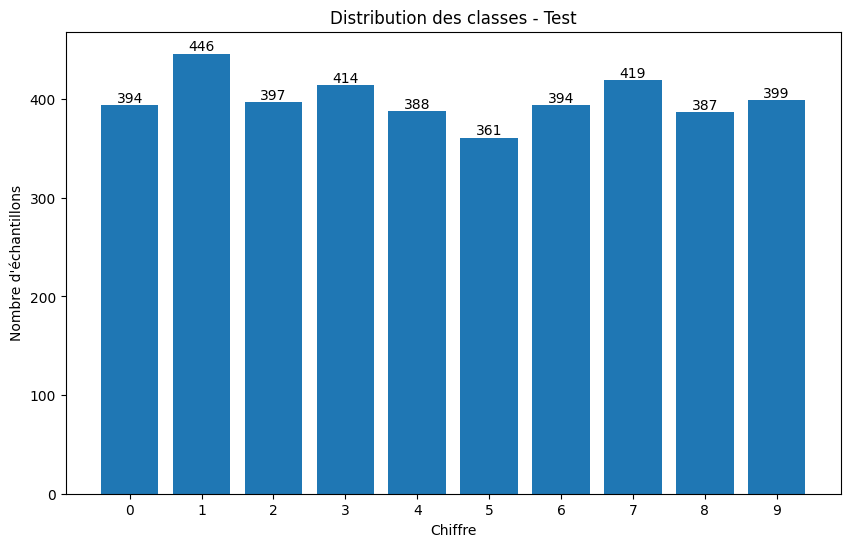

In [38]:
print("=== VISUALISATION DES DONNÉES ===")

# Échantillon d'images
pipeline.visualizer.plot_sample_images_with_label(X_train, y_train, save_fig=True)

# Distribution des classes
pipeline.visualizer.plot_class_distribution(y_train, "Train", save_fig=True)
pipeline.visualizer.plot_class_distribution(y_val, "Validation", save_fig=True)
pipeline.visualizer.plot_class_distribution(y_test, "Test", save_fig=True)

#### 3.5- Construction et training du model

##### 3.5.1- Construction

In [39]:
print("=== CONSTRUCTION ET ENTRAÎNEMENT DU MODÈLE ===")

# Construction du modèle
pipeline.model = CNNModel(pipeline.config)
model = pipeline.model.build_model("mnist_cnn")

=== CONSTRUCTION ET ENTRAÎNEMENT DU MODÈLE ===
Construction du modèle: mnist_cnn


E0000 00:00:1759924526.012873   48425 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1759924539.423646   48425 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Modèle compilé avec succès!


##### 3.5.2- Architecture

In [40]:
# Affichage de l'architecture
print("Architecture du modèle:")
model.summary()

Architecture du modèle:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,734,666 (6.62 MB)

 Trainable params: 1,733,706 (6.61 MB)

 Non-trainable params: 960 (3.75 KB)

##### 3.5.3- Training

In [41]:
# Entraînement
print("Début de l'entraînement...")
results = pipeline.model.train(X_train, y_train, X_val, y_val,
                              model_name="mnist_cnn", epochs=30)

Début de l'entraînement...
Début de l'entraînement pour 30 epochs...


/run/media/kjd/working/projects/IA/Stage_INSEED/OCR_CNN_MNIST_2/ocrcnnmnist2venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
  1/525 ━━━━━━━━━━━━━━━━━━━━ 4:15:39 29s/step - accuracy: 0.1406 - loss: 3.8823

2025-10-08 11:57:25.099914: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 20321280 exceeds 10% of free system memory.
2025-10-08 11:57:25.099978: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 20321280 exceeds 10% of free system memory.


  2/525 ━━━━━━━━━━━━━━━━━━━━ 1:47 206ms/step - accuracy: 0.1328 - loss: 3.8171 

2025-10-08 11:57:25.321588: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 20321280 exceeds 10% of free system memory.
2025-10-08 11:57:25.322490: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 20321280 exceeds 10% of free system memory.


  3/525 ━━━━━━━━━━━━━━━━━━━━ 1:48 208ms/step - accuracy: 0.1319 - loss: 3.7548

2025-10-08 11:57:25.543942: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 20321280 exceeds 10% of free system memory.


525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6150 - loss: 1.3100
Epoch 1: saving model to /run/media/kjd/working/projects/IA/Stage_INSEED/OCR_CNN_MNIST_2/Models/checkpoints/mnist_cnn_epoch_01.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 202s 330ms/step - accuracy: 0.7735 - loss: 0.7389 - val_accuracy: 0.8782 - val_loss: 0.5037 - learning_rate: 0.0010
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9238 - loss: 0.2480
Epoch 2: saving model to /run/media/kjd/working/projects/IA/Stage_INSEED/OCR_CNN_MNIST_2/Models/checkpoints/mnist_cnn_epoch_02.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 107s 204ms/step - accuracy: 0.9324 - loss: 0.2268 - val_accuracy: 0.9852 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9501 - loss: 0.1656
Epoch 3: saving model to /run/media/kjd/working/projects/IA/Stage_INSEED/OCR_CNN_MNIST_2/Models/checkpoints/mnist_cnn_epoch_03.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 109s 207ms/step - accuracy: 0

#### 3.6- Visualisation des résultats de training

=== VISUALISATION DES RÉSULTATS D'ENTRAÎNEMENT ===


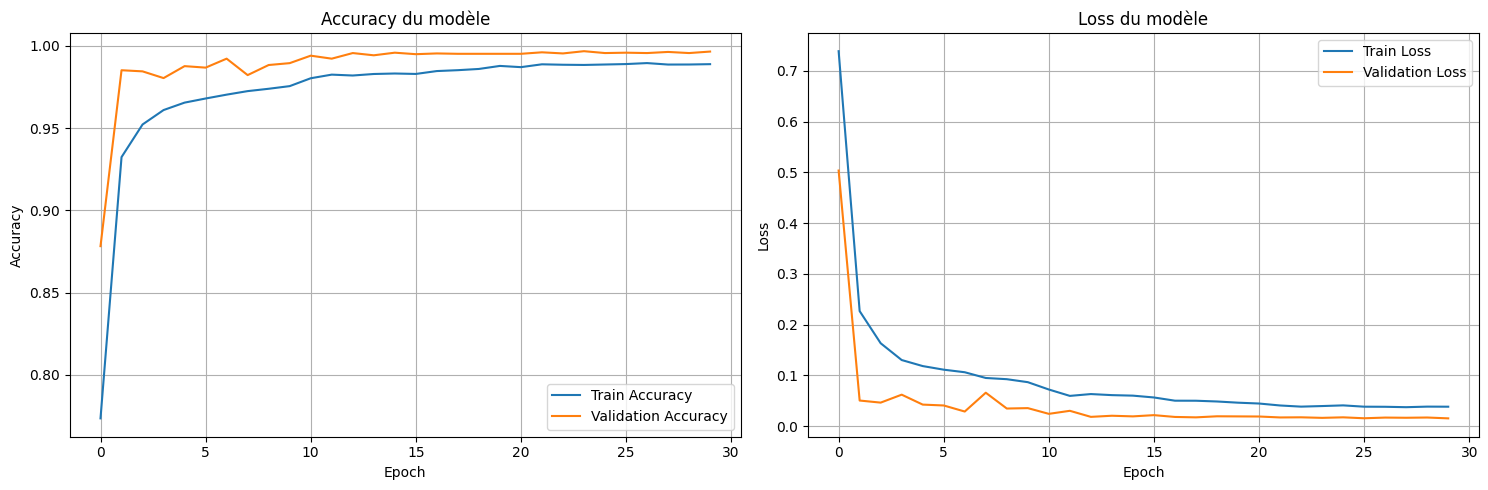

In [42]:
print("=== VISUALISATION DES RÉSULTATS D'ENTRAÎNEMENT ===")

# Historique d'entraînement
pipeline.visualizer.plot_training_history(results, save_fig=True)

#### 3.7- Résultats d'évaluation

=== RESULTATS DE L'EVALUATION ===
Évaluation du modèle...
Loss sur le test set: 0.0144
Accuracy sur le test set: 0.9950
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step


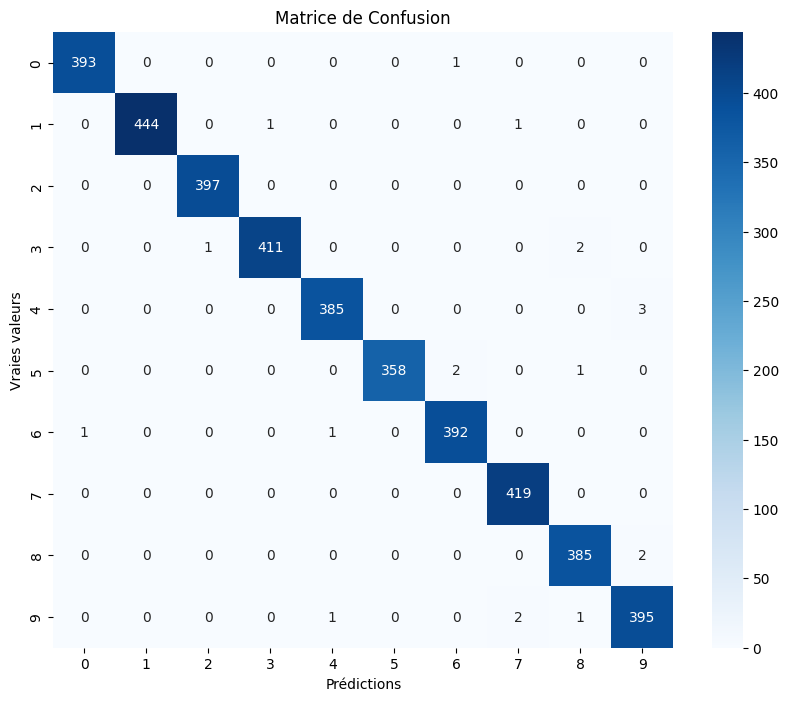

Rapport de classification détaillé:
              precision    recall  f1-score   support

           0     0.9975    0.9975    0.9975       394
           1     1.0000    0.9955    0.9978       446
           2     0.9975    1.0000    0.9987       397
           3     0.9976    0.9928    0.9952       414
           4     0.9948    0.9923    0.9935       388
           5     1.0000    0.9917    0.9958       361
           6     0.9924    0.9949    0.9937       394
           7     0.9929    1.0000    0.9964       419
           8     0.9897    0.9948    0.9923       387
           9     0.9875    0.9900    0.9887       399

    accuracy                         0.9950      3999
   macro avg     0.9950    0.9949    0.9950      3999
weighted avg     0.9950    0.9950    0.9950      3999



In [43]:
print("=== RESULTATS DE L'EVALUATION ===")

# Évaluation
loss, accuracy = pipeline.model.evaluate(X_test, y_test)

# Matrice de confusion
y_pred = pipeline.model.predict(X_test)
y_true = y_test
pipeline.visualizer.plot_confusion_matrix(y_true, y_pred, save_fig=True)

# Rapport détaillé
print("Rapport de classification détaillé:")
print(classification_report(y_true, y_pred, digits=4))

#### 3.8- Sauvegarde des rslts et métriques

In [44]:
print("=== SAUVEGARDE DES RÉSULTATS ===")

# Sauvegarde des métriques finales
final_metrics = {
    'test_accuracy': accuracy,
    'test_loss': loss,
    'training_epochs': len(results.history['accuracy']),
    'best_validation_accuracy': max(results.history['val_accuracy']),
    'best_validation_loss': min(results.history['val_loss']),
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_architecture': 'CNN avec 3 couches convolutionnelles',
    'parameters': {
        'input_shape': (28, 28, 1),
        'num_classes': 10,
        'optimizer': 'Adam',
        'learning_rate': 0.001
    }
}

# Sauvegarde des métriques
metrics_path = os.path.join(pipeline.config.base_output_dir, 'final_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(final_metrics, f, indent=4)

print(f"Métriques sauvegardées: {metrics_path}")
print(f"Accuracy sur test: {accuracy:.4f}")
print(f"Meilleure accuracy validation: {max(results.history['val_accuracy']):.4f}")

=== SAUVEGARDE DES RÉSULTATS ===
Métriques sauvegardées: /run/media/kjd/working/projects/IA/Stage_INSEED/OCR_CNN_MNIST_2/Outputs/final_metrics.json
Accuracy sur test: 0.9950
Meilleure accuracy validation: 0.9968


## --

In [ ]:
directory = "/run/media/kjd/working/projects/IA/Stage_INSEED/OCR_CNN_MNIST/Outputs"

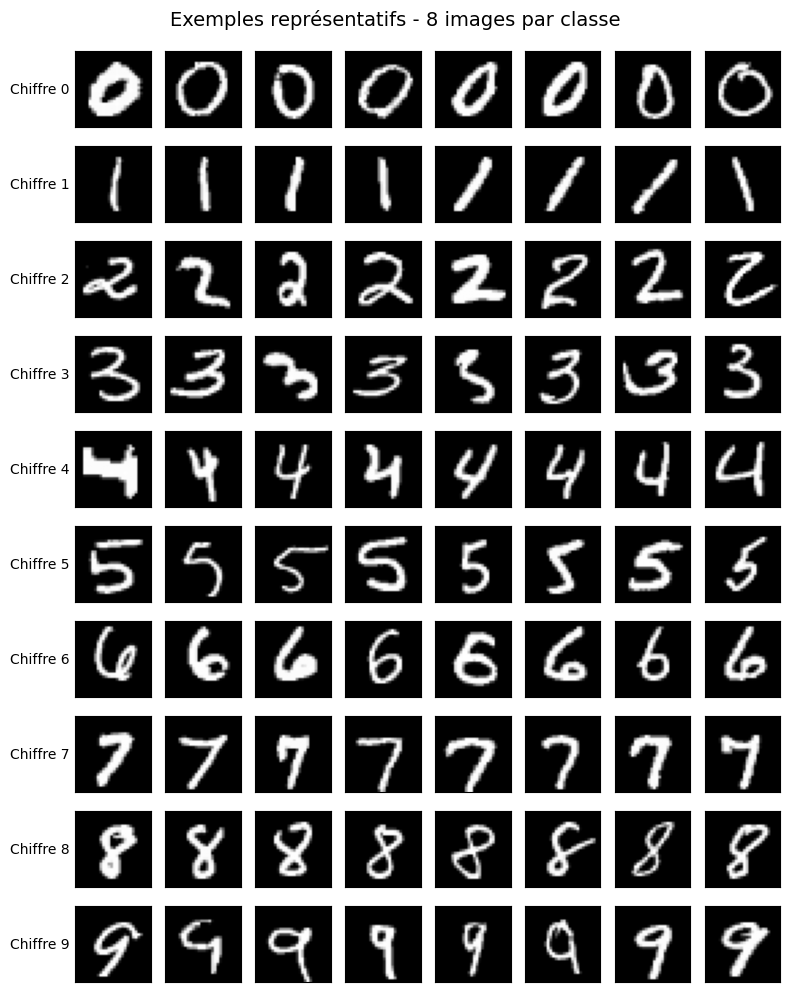

In [ ]:
def plot_compact_examples(X, y, examples_per_class=10):
    """
    Version compacte pour annexe de rapport
    """
    fig, axes = plt.subplots(10, examples_per_class, figsize=(examples_per_class, 10))

    plt.suptitle(f'Exemples représentatifs - {examples_per_class} images par classe', 
                fontsize=14, y=0.99)
    
    for digit in range(10):
        indices = np.where(y == digit)[0][:examples_per_class]
        
        for j, idx in enumerate(indices):
            ax = axes[digit, j]
            ax.imshow(X[idx].squeeze(), cmap='gray')
            
            # Ajouter le label seulement sur la première colonne
            if j == 0:
                ax.set_ylabel(f'Chiffre {digit}', rotation=0, ha='right', va='center')
            
            ax.set_xticks([])
            ax.set_yticks([])
    
    
    plt.tight_layout()
    plt.savefig(f"{directory}/graphics/exemples_compact_annexe.png", dpi=300, bbox_inches='tight')
    plt.show()

# Utilisation
plot_compact_examples(X_train, y_train, examples_per_class=8)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Exemples corrects: 3979
Exemples incorrects: 20


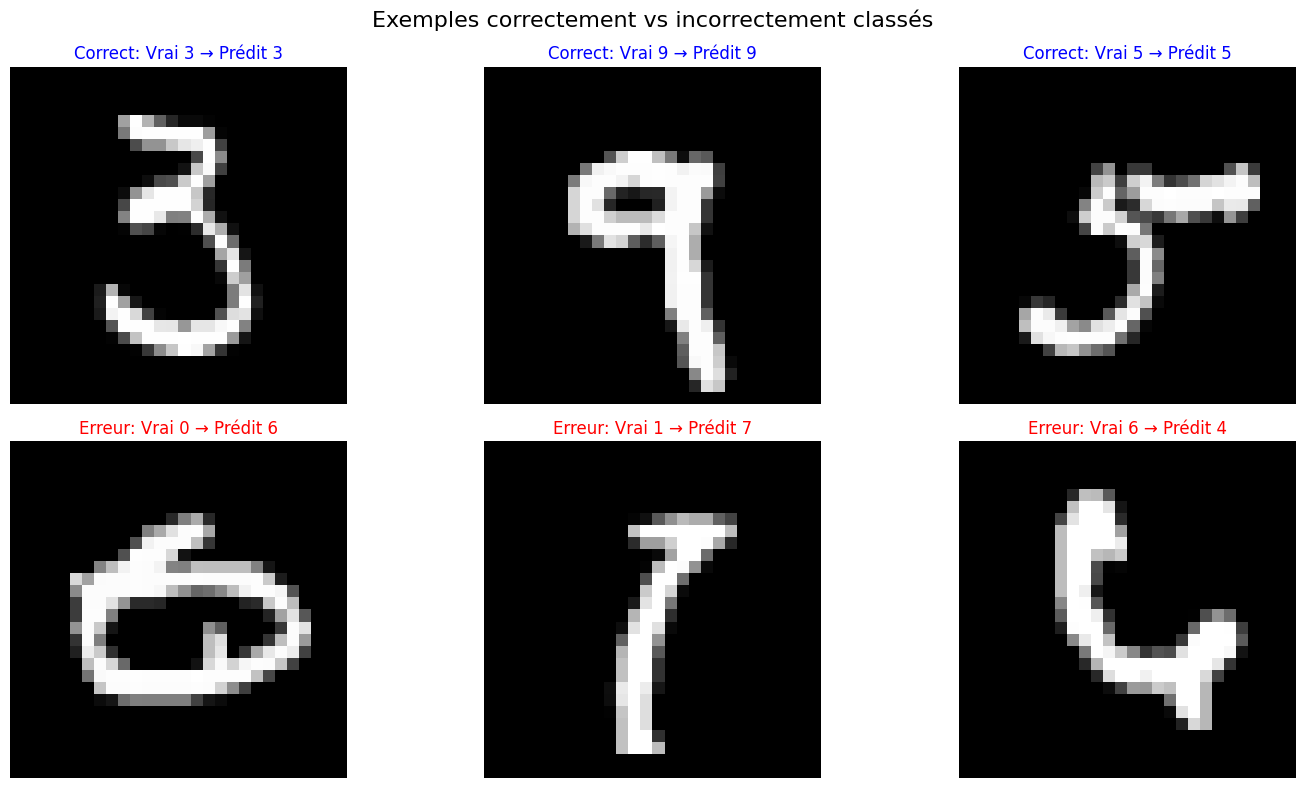

In [ ]:
def plot_correct_vs_incorrect(model, X, y, num_examples=3):
    """
    Affiche des exemples correctement et incorrectement classés
    """
    y_pred = np.argmax(model.predict(X), axis=1)
    
    correct_indices = np.where(y_pred == y)[0]
    incorrect_indices = np.where(y_pred != y)[0]
    
    print(f"Exemples corrects: {len(correct_indices)}")
    print(f"Exemples incorrects: {len(incorrect_indices)}")
    
    # Afficher quelques erreurs
    if len(incorrect_indices) > 0:
        fig, axes = plt.subplots(2, min(num_examples, len(incorrect_indices)), figsize=(15, 8))
        
        if min(num_examples, len(incorrect_indices)) == 1:
            axes = axes.reshape(2, 1)
        
        # Exemples corrects
        for i in range(min(num_examples, len(correct_indices))):
            idx = correct_indices[i]
            ax = axes[0, i] if num_examples > 1 else axes[0]
            ax.imshow(X[idx].squeeze(), cmap='gray')
            ax.set_title(f'Correct: Vrai {y[idx]} → Prédit {y_pred[idx]}', color='blue')
            ax.axis('off')
        
        # Exemples incorrects
        for i in range(min(num_examples, len(incorrect_indices))):
            idx = incorrect_indices[i]
            ax = axes[1, i] if num_examples > 1 else axes[1]
            ax.imshow(X[idx].squeeze(), cmap='gray')
            ax.set_title(f'Erreur: Vrai {y[idx]} → Prédit {y_pred[idx]}', color='red')
            ax.axis('off')
        
        plt.suptitle('Exemples correctement vs incorrectement classés', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{directory}/graphics/correct_vs_incorrect.png", dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Aucune erreur de classification!")

# Utilisation
plot_correct_vs_incorrect(model, X_test, y_test, num_examples=3)

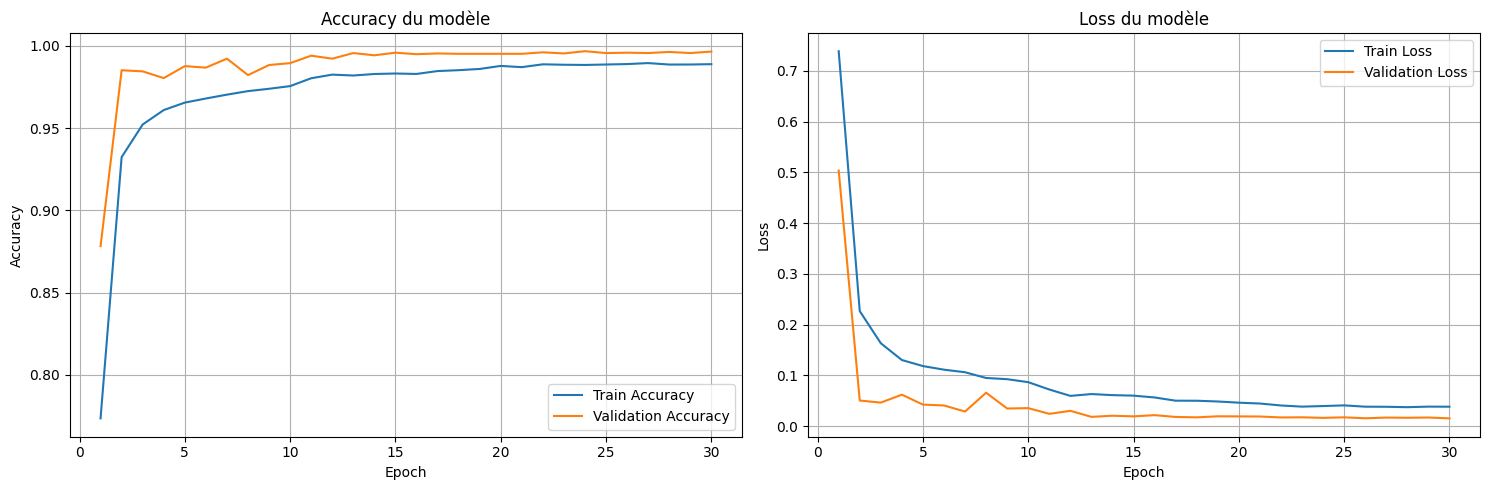

In [ ]:
history = pd.read_csv(f"{directory}/training_logs/mnist_cnn_training_20251008_115645.csv", index_col=0)


def plot_training_history(history, save_fig=False):
    """Affiche l'historique d'entraînement"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history['accuracy'], label='Train Accuracy')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Accuracy du modèle')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history['loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss du modèle')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    if save_fig:
        plt.savefig(f"{directory}/graphics/training_history_remaked.png",
                    dpi=300, bbox_inches='tight')
    plt.show()


plot_training_history(history, save_fig=True)